# Catcha Solver using Neural Network

This code is heavily based on the following tutorial: https://keras.io/examples/vision/captcha_ocr/. The main difference is that I use my own dataset (with different letter spacing, rotation, colors, blur, fonts, etc.) and I use more layers in the neural network. You can find the code to create your own dataset in CaptchaGenerator file.

In [103]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from custom_layers import CTCLayer

In [104]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Get the dataset

In [105]:
#!curl -LO https://github.com/AakashKumarNain/CaptchaCracker/raw/master/captcha_images_v2.zip
#!unzip -qq captcha_images_v2.zip

In [106]:
# Path to the data directory
# Get path from json
json_file = Path("./config.json").read_text()
json_data = json.loads(json_file)

data_dir = Path(json_data["dataset_dir"])

data_dir = data_dir / "rotated-data"
#data_dir = Path("./captcha_images_v2/")

model_dir = Path("./models/")

# Get list of all the images
images = sorted(list(map(str, list(data_dir.glob("*.png")))))
labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in images]

# Maximum length of any captcha in the dataset
max_length = max([len(label) for label in labels])

labels = [label + ("-" * (max_length - len(label))) for label in labels]

characters = set(char for label in labels for char in label if char != "-")
characters = sorted(list(characters))

print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

Number of images found:  180000
Number of labels found:  180000
Number of unique characters:  26
Characters present:  ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


## Define data encoding and decoding functions

In [107]:
# Batch size for training and validation
batch_size = 16

# Desired image dimensions
img_width = 200
img_height = 70

# Factor by which the image is going to be downsampled
# by the convolutional blocks. We will be using three
# convolution blocks and each block will have
# a pooling layer which downsample the features by a factor of 3.
# Hence total downsampling factor would be 2^3.
downsample_factor = 8

In [108]:
# Mapping characters to integers
char_to_num = layers.StringLookup(
    vocabulary=list(characters), mask_token=None
)

# Mapping integers back to original characters
num_to_char = layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

In [109]:
def split_data(images, labels, train_size=0.9, shuffle=True):
    ''' 
    Split dataset into training and validation sets.
    
    :param images: Array of image paths
    :param labels: Array of labels
    :param train_size: Size of training set. Defaults to 90% of entire dataset
    :param shuffle: Whether to shuffle dataset. Defaults to True
    :return: x_train, x_valid, y_train, y_valid
    '''

    # 1. Get the total size of the dataset
    size = len(images)

    # 2. Make an indices array and shuffle it, if required
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)

    # 3. Get the size of training samples
    train_samples = int(size * train_size)

    # 4. Split data into training and validation sets
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    
    return x_train, x_valid, y_train, y_valid

In [110]:
def encode_single_sample(img_path, label):
    ''' 
    Encode images and labels into tensors. The image is converted to grayscale (values from 0 to 1).
    The label is converted to a list of integers corresponding to the character index in characters variable.
    
    :param img_path: Path to image
    :param label: Label associated with the image
    :return: Tuple of image tensor and labels tensor
    '''

    # 1. Read image
    img = tf.io.read_file(img_path)

    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1)

    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)

    # 4. Resize to the desired size
    img = tf.image.resize(img, [img_height, img_width])

    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
    img = tf.transpose(img, perm=[1, 0, 2])

    # 6. Map the characters in label to numbers
    # unicode split will convert the string to list of chars
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))

    # 7. Return a dict as our model is expecting two inputs
    return {"image": img, "label": label}

In [111]:
# Splitting data into training and validation sets
x_train, x_valid, y_train, y_valid = split_data(np.array(images), np.array(labels))

#### Example

In [112]:
# Example
print(x_train.shape, x_valid.shape, x_train[0], y_train[0])

img_path = x_train[0]
label = y_train[0]

img = tf.io.read_file(img_path)
img = tf.io.decode_png(img, channels=1)
img = tf.image.convert_image_dtype(img, tf.float32)
img = tf.image.resize(img, [img_height, img_width])
img = tf.transpose(img, perm=[1, 0, 2])
label += "-" * (max_length - len(label))

print(tf.strings.unicode_split(label, input_encoding="UTF-8"))
label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
print(label)

(162000,) (18000,) C:\Users\sebge\source\repos\Captcha Data\rotated-data\pwohtcbgi.png pwohtcbgi-
tf.Tensor([b'p' b'w' b'o' b'h' b't' b'c' b'b' b'g' b'i' b'-'], shape=(10,), dtype=string)
tf.Tensor([16 23 15  8 20  3  2  7  9  0], shape=(10,), dtype=int64)


In [113]:
y_train[:5]

array(['pwohtcbgi-', 'czqeovmlfy', 'ohzkayx---', 'ldeqvojzun',
       'bqutknc---'], dtype='<U10')

### Define the training and validation datasets

In [114]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

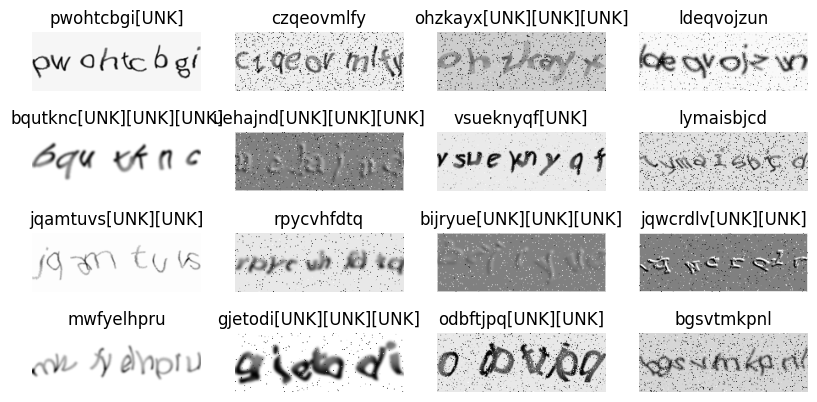

In [115]:
_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

## Define the model

In [116]:
def build_model():
    # Inputs to the model
    input_img = layers.Input(
        shape=(img_width, img_height, 1), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    # First conv block
    x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",  # Truncated std normal
        padding="same",  # Sides are padded with zeros
        name="Conv1",
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block
    x = layers.Conv2D(
        128,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    # Third conv block
    x = layers.Conv2D(
        256,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv3",
    )(x)
    x = layers.MaxPooling2D((2, 2), name="pool3")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 8x smaller. The number of
    # filters in the last layer is 256. Reshape accordingly before
    # passing the output to the RNN part of the model
    new_shape = ((img_width // downsample_factor), (img_height // downsample_factor) * 256)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(1024, activation="relu", name="dense1.1")(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(256, activation="relu", name="dense1.2")(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(64, activation="relu", name="dense1.3")(x)
    x = layers.Dropout(0.2)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output layer (of shape 25x(len vocab + 1)), 25 is the max length of the captcha (200 columns reduced to 25 by maxpooling)
    x = layers.Dense(
        len(char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense2"
    )(x)

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )
    # Optimizer
    opt = keras.optimizers.Adam()
    # Compile the model and return
    model.compile(optimizer=opt)
    return model


# Get the model
model = build_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 200, 70, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 200, 70, 64)  640         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 100, 35, 64)  0           ['Conv1[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 100, 35, 128  73856       ['pool1[0][0]']       

## Train the model

In [124]:
epochs = 100
early_stopping_patience = 50
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping],
)

Epoch 1/100
10125/10125 [==============================] - 426s 42ms/step - loss: 6.0696 - val_loss: 4.5135
Epoch 2/100
10125/10125 [==============================] - 398s 39ms/step - loss: 6.1586 - val_loss: 5.1365
Epoch 3/100
10125/10125 [==============================] - 399s 39ms/step - loss: 6.0994 - val_loss: 4.7358
Epoch 4/100
 1368/10125 [===>..........................] - ETA: 5:21 - loss: 6.3321

## Feedback on the training

In [119]:
# Save model
model_name = f'{model_dir}/model-c64-c128-c256-d1024-d256-d64-bs16-ep50-rotated'
model.save(f'{model_name}.h5')

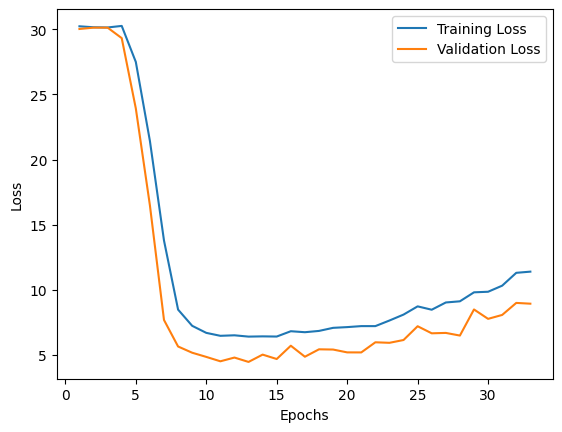

In [120]:
loss_values = history.history['loss']
loss_validation_values = history.history['val_loss']


epochs = range(1, len(loss_values)+1)

plt.plot(epochs, loss_values, label='Training Loss')
plt.plot(epochs, loss_validation_values, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# save plot to file
plt.savefig(f'{model_name}.png')

plt.show()


In [121]:
# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)  # Removes the CTC layer

In [122]:
# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)
    
    # First 0 is to get the grid (row for each image in the batch, column for each character: 8 12 4 5 -1 -1 -1 -1 -1)
    results = results[0][0][
        :, :max_length
    ]
    print(results.shape)

    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

(16, 200, 70, 1)
1/1 [==============================] - 1s 1s/step
(16, 10)


FileNotFoundError: [Errno 2] No such file or directory: 'predictions-models/model-c64-c128-c256-d1024-d256-d64-bs16-ep50-rotated.png'

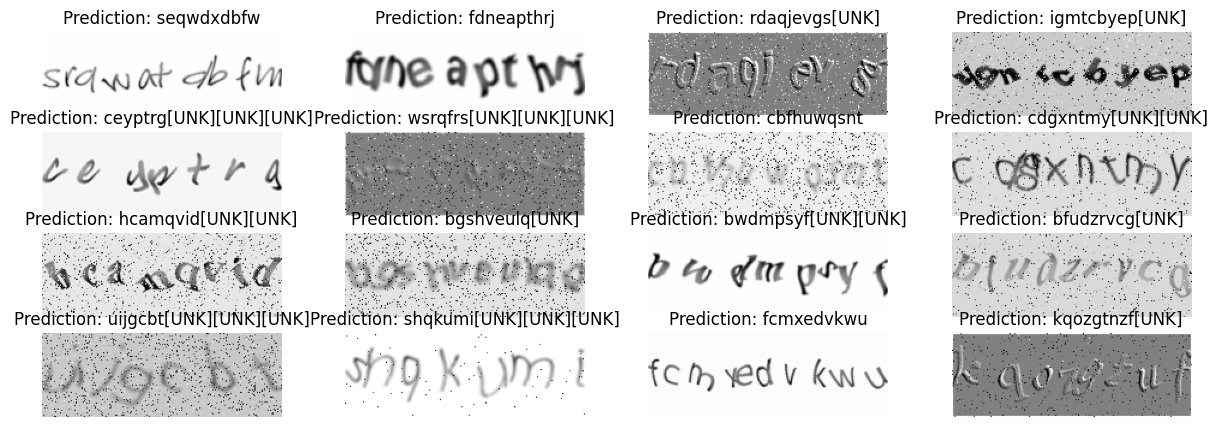

In [123]:
#  Let's check results on some validation samples
for batch in validation_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]
    print(batch_images.shape)
    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")

plt.savefig(f'predictions-{model_name}.png')
plt.show()